# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 8: Ensembles: Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the [instructions given in Canvas](https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions).

- If needed, clarifications will be posted on Piazza.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below. 


**Name of the person you have worked with goes here:**
<br><BR>

## Learning Objectives
Completing this assignment will demonstrate success at the following objectives:

- Statistical
  - Predict when bagging will help model performance.
  - Identify how Random Forests improve over bagging.
  - Predict when boosting will help model performance.
  - Compare and contrast bagging and boosting.
- Coding
  - Identify and fix problems in poorly written code
- Communication
  - Visually explain a complex concept

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

<div class="theme"> Overview: Higgs Boson Discovery </div>

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [3]:
# Load data
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

print(f"{len(data_train)} training samples, {len(data_test)} test samples")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training samples, 5000 test samples

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [4]:
display(data_train.head())
display(data_train.describe())

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


In [5]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values

<div class="exercise"> <b> Question 1: A Single Model [20 pts]</b> </div>

We start by fitting a basic model we can compare the other models to. We'll pick a decision tree as the base model, because we'll later include random forests and want a fair comparison. We'll tune the decision tree using cross-validation. As usual, we'll be tuning the maximum tree depth; we refer to this parameter as "depth" for simplicity.

Since we will only be using tree-based methods in this homework, we do not need to standardize or normalize the predictors.



**1.1**: Fit a decision tree model to the training set. Choose a range of tree depths to evaluate. Plot the estimated performance +/- 2 standard deviations for each depth using 5-fold cross validation. Also include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance.

*Hint*: use `plt.fill_between` to shade the region.

**1.2** Select an appropriate depth and justify your choice. Using your cross-validation estimates, report the mean +/- 2 stdev. Then report the classification accuracy on the test set. (Store the training and test accuracies in variables to refer to in a later question.)

**1.3** What is the mechanism by which limiting the depth of the tree avoids over-fitting? What is one downside of limiting the tree depth? Your answer should refer to the bias-variance trade-off.

**Answers**

**1.1**

In [6]:
# your code here
for i in range(2,11):
    cls = DecisionTreeClassifier(max_depth = i)
    score = cross_val_score(cls, X_train, y_train, cv=5)
    mean = (score[0]+score[1]+score[2]+score[3]+score[4])/5
    words = "The mean is: "
    print(i, score, words, mean)

2 [0.61738262 0.6003996  0.638      0.62862863 0.62262262] The mean is:  0.6214066938066938
3 [0.61738262 0.58741259 0.631      0.63563564 0.63463463] The mean is:  0.621213095013095
4 [0.63536464 0.62237762 0.637      0.64864865 0.65365365] The mean is:  0.639408912008912
5 [0.63636364 0.63436563 0.656      0.64964965 0.63963964] The mean is:  0.6432037120037121
6 [0.62637363 0.63436563 0.624      0.63863864 0.64764765] The mean is:  0.6342051094051093
7 [0.62437562 0.63336663 0.627      0.64564565 0.63563564] The mean is:  0.6332047078047077
8 [0.61138861 0.63236763 0.622      0.62962963 0.62662663] The mean is:  0.6244025000025
9 [0.6003996  0.63836164 0.613      0.60760761 0.64064064] The mean is:  0.6200018974018974
10 [0.60739261 0.6003996  0.609      0.61361361 0.61961962] The mean is:  0.6100050882050883


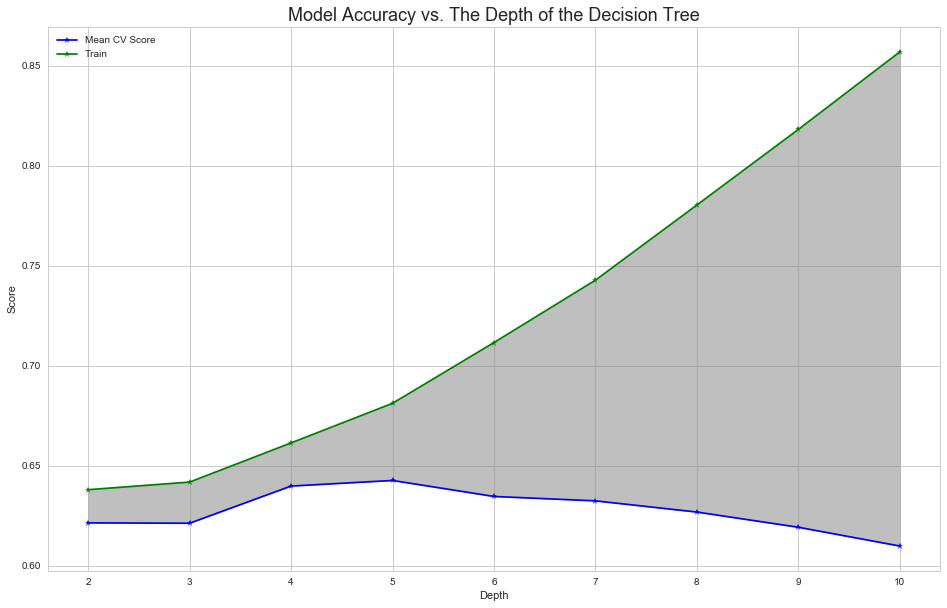

In [7]:
# your code here
depths = [2,3,4,5,6,7,8,9,10]
scores = []
scores_train = []
mean_CV_score = []
for depth in depths:
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(X_train, y_train)
    scores.append(dt.score(X_test, y_test))
    scores_train.append(dt.score(X_train, y_train))
    mean_CV_score.append(np.mean(cross_val_score(DecisionTreeClassifier(criterion='gini',max_depth=depth),X_train, y_train, scoring = 'accuracy', cv=5)))
  

fig, ax = plt.subplots(figsize=(16,10))
plt.plot(depths, mean_CV_score, 'b*-', label = 'Mean CV Score')
plt.plot(depths, scores_train, 'g*-', label = 'Train')
plt.fill_between(depths,mean_CV_score,scores_train, color = 'grey', alpha = 0.5)
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Model Accuracy vs. The Depth of the Decision Tree', size = 18)
plt.legend();

In [8]:
print(scores_train)

[0.638, 0.6418, 0.6614, 0.6812, 0.7116, 0.7428, 0.7804, 0.8182, 0.857]


**1.2**

In [9]:
# Selecting a depth of 5
cls = DecisionTreeClassifier(max_depth = 5)
score = cross_val_score(cls, X_train, y_train, cv=5)
mean = (score[0]+score[1]+score[2]+score[3]+score[4])/5
print(score, mean)

[0.63536464 0.63336663 0.653      0.64964965 0.63963964] 0.6422041116041116


In [10]:
score = cross_val_score(cls, X_test, y_test, cv=5)
mean = (score[0]+score[1]+score[2]+score[3]+score[4])/5
print(score, mean)

[0.64435564 0.67432567 0.647      0.62362362 0.67067067] 0.6519951225951226


**Answer** With a depth of 5, the model achieves a score of 0.65 on the test data.


**1.3**

The mechanism we use is the manual inspection of the CV score. Without our ability to interpret this, the tree would continue to grow until it had enough perturbations to capture every training set data point correctly. Specifically, we use 5-fold cross validation across the training data. Once that CV score is maximized (here, at a depth of 5), the tree is at an ideal depth. We could continue to add depth to our tree, which would result in a low-bias/high variance model. We don't want our model to be overfit to our training data (high variance), so we accept a certain level of bias in order to avoid overfitting.


<div class="exercise"> <b> Question 2: Bagging [25 pts]</b> </div>

Bagging is the technique of building the same model on multiple bootstraps from the data and combining each model's prediction to get an overall classification. In this question we build an example by hand and study how the number of bootstrapped datasets impacts the accuracy of the resulting classification.



**2.1** Choose a tree depth that will overfit the training set. What evidence leads you to believe that this depth will overfit? Assign your choice to a variable here. (You may want to explore different settings for this value in the problems below.)

**2.2** Create 45 bootstrapped replications of the original training data, and fit a decision tree to each. Use the tree depth you just chose in 2.1. Record each tree's prediction. In particular, produce a dataset like those below, where each row is a training (or test) example, each column is one of the trees, and each entry is that tree's prediction for that example. (Labeling the rows and columns is optional.)

Store these results as `bagging_train` and `bagging_test`. Don't worry about visualizing these results yet.

**2.3** _Aggregate_ all 45 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test-set accuracy is at least as good as the accuracy for the model you fit in Question 1.

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function (given below) to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracies as a function of number of bootstraps.

On your plot, also include horizontal lines for two baselines:
- the test accuracy of the best model from question 1
- the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single depth-10 tree. Explain the differences you see.

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 1.5.

**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

**Answers**:

**2.1**

**Answer:** A tree depth of 8 would overfit the training data. We see that the accuracy score for the training data improves from 0.68 to 0.78, but the mean CV score falls from 0.64 to 0.62


In [11]:
#Assign an overfit depth of 8
depth_over = 8

**2.2**

**Structure of `bagging_train` and `bagging_test`:**

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|
| --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|
| --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |


In [54]:
# your code here
train_rows = []
test_rows = []
columns = []
for i in range (1, 5001):
    words_1 = "training row %s" %i
    words_2 = "test row %s" %i
    train_rows.append(words_1)
    test_rows.append(words_2)
for i in range (1,46):
    words_3 = "bootstrap model %s's prediction" %i
    columns.append(words_3)
    
#Comment  
data_train = np.zeros(shape=(5000,45))
data_test = np.zeros(shape=(5000,45))
# X, y = resample(X_train, y_train, n_samples = 1)
for i in range (0,45):
    X, y = resample(X_train, y_train, n_samples = 5000)
    dt = tree.DecisionTreeClassifier(max_depth = depth_over)
    dt.fit(X,y)
    y_pred_train = dt.predict(X)
    y_pred_test = dt.predict(X_test)
    data_train[:,i]=y_pred_train
    data_test[:,i]=y_pred_test
bagging_train = pd.DataFrame(data_train, columns = columns)
bagging_test = pd.DataFrame(data_test, index = test_rows, columns = columns)

,bootstrap model 1's prediction,bootstrap model 2's prediction,bootstrap model 3's prediction,bootstrap model 4's prediction,bootstrap model 5's prediction,bootstrap model 6's prediction,bootstrap model 7's prediction,bootstrap model 8's prediction,bootstrap model 9's prediction,bootstrap model 10's prediction,bootstrap model 11's prediction,bootstrap model 12's prediction,bootstrap model 13's prediction,bootstrap model 14's prediction,bootstrap model 15's prediction,bootstrap model 16's prediction,bootstrap model 17's prediction,bootstrap model 18's prediction,bootstrap model 19's prediction,bootstrap model 20's prediction,bootstrap model 21's prediction,bootstrap model 22's prediction,bootstrap model 23's prediction,bootstrap model 24's prediction,bootstrap model 25's prediction,bootstrap model 26's prediction,bootstrap model 27's prediction,bootstrap model 28's prediction,bootstrap model 29's prediction,bootstrap model 30's prediction,bootstrap model 31's prediction,bootstrap model 32's prediction,bootstrap model 33's prediction,bootstrap model 34's prediction,bootstrap model 35's prediction,bootstrap model 36's prediction,bootstrap model 37's prediction,bootstrap model 38's prediction,bootstrap model 39's prediction,bootstrap model 40's prediction,bootstrap model 41's prediction,bootstrap model 42's prediction,bootstrap model 43's prediction,bootstrap model 44's prediction,bootstrap model 45's prediction
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.0000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.523800,0.498400,0.55460,0.563000,0.532200,0.532800,0.553600,0.566400,0.502800,0.502000,0.543800,0.511200,0.521400,0.512400,0.573600,0.56280,0.523800,0.522600,0.572200,0.510600,0.557600,0.549600,0.502000,0.532200,0.545000,0.528600,0.577800,0.524600,0.583400,0.568200,0.56120,0.517800,0.52880,0.470600,0.57600,0.578200,0.530600,0.546800,0.5418,0.473600,0.51380,0.551800,0.501400,0.519200,0.533800
std,0.499483,0.500047,0.49706,0.496065,0.499012,0.498973,0.497168,0.495621,0.500042,0.500046,0.498128,0.499925,0.499592,0.499896,0.494603,0.49609,0.499483,0.499539,0.494809,0.499938,0.496721,0.497584,0.500046,0.499012,0.498021,0.499231,0.493959,0.499444,0.493045,0.495376,0.49629,0.499733,0.49922,0.499185,0.49424,0.493896,0.499113,0.497855,0.4983,0.499352,0.49986,0.497359,0.500048,0.499681,0.498906
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,0.000000,1.00000,1.000000,1.000000,1.000000,1.0000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.

In [56]:
display(bagging_train, bagging_test)

,bootstrap model 1's prediction,bootstrap model 2's prediction,bootstrap model 3's prediction,bootstrap model 4's prediction,bootstrap model 5's prediction,bootstrap model 6's prediction,bootstrap model 7's prediction,bootstrap model 8's prediction,bootstrap model 9's prediction,bootstrap model 10's prediction,bootstrap model 11's prediction,bootstrap model 12's prediction,bootstrap model 13's prediction,bootstrap model 14's prediction,bootstrap model 15's prediction,bootstrap model 16's prediction,bootstrap model 17's prediction,bootstrap model 18's prediction,bootstrap model 19's prediction,bootstrap model 20's prediction,bootstrap model 21's prediction,bootstrap model 22's prediction,bootstrap model 23's prediction,bootstrap model 24's prediction,bootstrap model 25's prediction,bootstrap model 26's prediction,bootstrap model 27's prediction,bootstrap model 28's prediction,bootstrap model 29's prediction,bootstrap model 30's prediction,bootstrap model 31's prediction,bootstrap model 32's prediction,bootstrap model 33's prediction,bootstrap model 34's prediction,bootstrap model 35's prediction,bootstrap model 36's prediction,bootstrap model 37's prediction,bootstrap model 38's prediction,bootstrap model 39's prediction,bootstrap model 40's prediction,bootstrap model 41's prediction,bootstrap model 42's prediction,bootstrap model 43's prediction,bootstrap model 44's prediction,bootstrap model 45's prediction
0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
5,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
6,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
7,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
8,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
9,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


,bootstrap model 1's prediction,bootstrap model 2's prediction,bootstrap model 3's prediction,bootstrap model 4's prediction,bootstrap model 5's prediction,bootstrap model 6's prediction,bootstrap model 7's prediction,bootstrap model 8's prediction,bootstrap model 9's prediction,bootstrap model 10's prediction,bootstrap model 11's prediction,bootstrap model 12's prediction,bootstrap model 13's prediction,bootstrap model 14's prediction,bootstrap model 15's prediction,bootstrap model 16's prediction,bootstrap model 17's prediction,bootstrap model 18's prediction,bootstrap model 19's prediction,bootstrap model 20's prediction,bootstrap model 21's prediction,bootstrap model 22's prediction,bootstrap model 23's prediction,bootstrap model 24's prediction,bootstrap model 25's prediction,bootstrap model 26's prediction,bootstrap model 27's prediction,bootstrap model 28's prediction,bootstrap model 29's prediction,bootstrap model 30's prediction,bootstrap model 31's prediction,bootstrap model 32's prediction,bootstrap model 33's prediction,bootstrap model 34's prediction,bootstrap model 35's prediction,bootstrap model 36's prediction,bootstrap model 37's prediction,bootstrap model 38's prediction,bootstrap model 39's prediction,bootstrap model 40's prediction,bootstrap model 41's prediction,bootstrap model 42's prediction,bootstrap model 43's prediction,bootstrap model 44's prediction,bootstrap model 45's prediction
test row 1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
test row 2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
test row 3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
test row 4,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
test row 5,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
test row 6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
test row 7,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
test row 8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
test row 9,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
test row 10,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0


**2.3**:  _Aggregate_ all 45 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test-set accuracy is at least as good as the accuracy for the model you fit in Question 1.

In [13]:
# your code here
# For rows with mean value > .5, classify as 1; 

**2.4**

In [14]:
def running_predictions(prediction_dataset, targets):
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset, where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

In [15]:
# your code here


**2.5**

**your answer here**


**2.6**

**your answer here**


**2.7**

**your answer here**


<div class="exercise"> <b> Question 3: Random Forests [15 pts]</b> </div>

Random Forests are closely related to the bagging model we built by hand in question 2. In this question we compare our by-hand results with the results of using `RandomForestClassifier` directly.



**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees that you used in Question 2.2. Evaluate its accuracy on the test set.

**3.2** For each of the decision trees you fit in the bagging process, how many times is each feature used at the top node? How about for each tree in the random forest you just fit? What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs Random Forest?

**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.

**3.3**: Make a table of the training and test accuracy for the following models:

- Single tree with best depth chosen by cross-validation (from Question 1)
- A single overfit tree trained on all data (from Question 2, using the depth you chose there)
- Bagging 45 such trees (from Question 2)
- A Random Forest of 45 such trees (from Question 3.1)

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

**Answers**:

**3.1**

In [58]:
# your code here
# your code here
train_rows = []
test_rows = []
columns = []
for i in range (1, 5001):
    words_1 = "training row %s" %i
    words_2 = "test row %s" %i
    train_rows.append(words_1)
    test_rows.append(words_2)
for i in range (1,46):
    words_3 = "bootstrap model %s's prediction" %i
    columns.append(words_3)
    
#Comment  
data_train = np.zeros(shape=(5000,45))
data_test = np.zeros(shape=(5000,45))
for i in range (0,45):
    X, y = resample(X_train, y_train, n_samples = 5000)
    rf = RandomForestClassifier(max_depth = depth_over)
    rf.fit(X,y)
    y_pred_train = dt.predict(X)
    y_pred_test = dt.predict(X_test)
    data_train[:,i]=y_pred_train
    data_test[:,i]=y_pred_test
rf_train = pd.DataFrame(data_train, columns = columns)
rf_test = pd.DataFrame(data_test, index = test_rows, columns = columns)

In [59]:
display(rf_train, rf_test)

,bootstrap model 1's prediction,bootstrap model 2's prediction,bootstrap model 3's prediction,bootstrap model 4's prediction,bootstrap model 5's prediction,bootstrap model 6's prediction,bootstrap model 7's prediction,bootstrap model 8's prediction,bootstrap model 9's prediction,bootstrap model 10's prediction,bootstrap model 11's prediction,bootstrap model 12's prediction,bootstrap model 13's prediction,bootstrap model 14's prediction,bootstrap model 15's prediction,bootstrap model 16's prediction,bootstrap model 17's prediction,bootstrap model 18's prediction,bootstrap model 19's prediction,bootstrap model 20's prediction,bootstrap model 21's prediction,bootstrap model 22's prediction,bootstrap model 23's prediction,bootstrap model 24's prediction,bootstrap model 25's prediction,bootstrap model 26's prediction,bootstrap model 27's prediction,bootstrap model 28's prediction,bootstrap model 29's prediction,bootstrap model 30's prediction,bootstrap model 31's prediction,bootstrap model 32's prediction,bootstrap model 33's prediction,bootstrap model 34's prediction,bootstrap model 35's prediction,bootstrap model 36's prediction,bootstrap model 37's prediction,bootstrap model 38's prediction,bootstrap model 39's prediction,bootstrap model 40's prediction,bootstrap model 41's prediction,bootstrap model 42's prediction,bootstrap model 43's prediction,bootstrap model 44's prediction,bootstrap model 45's prediction
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
1,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
6,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
7,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
8,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
9,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


,bootstrap model 1's prediction,bootstrap model 2's prediction,bootstrap model 3's prediction,bootstrap model 4's prediction,bootstrap model 5's prediction,bootstrap model 6's prediction,bootstrap model 7's prediction,bootstrap model 8's prediction,bootstrap model 9's prediction,bootstrap model 10's prediction,bootstrap model 11's prediction,bootstrap model 12's prediction,bootstrap model 13's prediction,bootstrap model 14's prediction,bootstrap model 15's prediction,bootstrap model 16's prediction,bootstrap model 17's prediction,bootstrap model 18's prediction,bootstrap model 19's prediction,bootstrap model 20's prediction,bootstrap model 21's prediction,bootstrap model 22's prediction,bootstrap model 23's prediction,bootstrap model 24's prediction,bootstrap model 25's prediction,bootstrap model 26's prediction,bootstrap model 27's prediction,bootstrap model 28's prediction,bootstrap model 29's prediction,bootstrap model 30's prediction,bootstrap model 31's prediction,bootstrap model 32's prediction,bootstrap model 33's prediction,bootstrap model 34's prediction,bootstrap model 35's prediction,bootstrap model 36's prediction,bootstrap model 37's prediction,bootstrap model 38's prediction,bootstrap model 39's prediction,bootstrap model 40's prediction,bootstrap model 41's prediction,bootstrap model 42's prediction,bootstrap model 43's prediction,bootstrap model 44's prediction,bootstrap model 45's prediction
test row 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test row 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test row 3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
test row 4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
test row 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test row 6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
test row 7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test row 8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test row 9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test row 10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**3.2**

In [17]:
# your code here


**your answer here**


**3.3**

Fill in the following table (ideally in code, but ok to fill in this Markdown cell).


| classifier | training accuracy | test accuracy |
| --- | --- | --- |
| single tree with best depth chosen by CV | | |
| single depth-X tree | | |
| bagging 45 depth-X trees | | |
| Random Forest of 45 depth-X trees | | |

In [18]:
# your code here


**your answer here**


<div class="exercise"> <b> Question 4: Boosting [15 pts]</b> </div>

In this question we explore a different kind of ensemble method, boosting, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy as the algorithm adds more predictors to the ensemble.



**4.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

**4.2** The following code attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws. First, imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code. Then, imagine that you're the TF writing the solutions; make an excellent example implementation. Finally, use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.

**4.3** Now let's use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.

**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)

**4.5** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?

**Answers**

**4.1**

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

In [19]:
# your code here


In [20]:
# your code here


**your answer here**


**4.2**

The intended functionality is the following:
1. Fit `tree1`, a decision tree with max depth 3.
2. Construct an array of sample weights. Give a weight of 1 to samples that `tree1` classified correctly, and 2 to samples that `tree1` misclassified.
3. Fit `tree2`, another depth-3 decision tree, using those sample weights.
4. To predict, compute the probabilities that `tree1` and `tree2` each assign to the positive class. Take the average of those two probabilities as the prediction probability.

In [21]:
def boostmeup():
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X_train, y_train)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
      if tree1.predict([X_train[idx]]) != y_train[idx]:
         sample_weight[idx] = sample_weight[idx] * 2
         q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup()

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


**Your answer here**


In [22]:
# your code here


**4.3**

In [23]:
# your code here


**4.4**

In [24]:
# your code here


In [25]:
# your code here


**Your answer here**


**4.5**

In [26]:
# your code here


**Your answer here**


<div class="exercise"> <b> Question 5: Understanding [15 pts]</b> </div>

This question is an overall test of your knowledge of this homework's material. You may need to refer to lecture notes and other material outside this homework to answer these questions.



**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?


**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**5.5** Which of these techniques can be extended to regression tasks? How?

**Answers**:

**5.1**

**Your answer here**


**5.2**

**your answer here**


**5.3**

**Your answer here**


**5.4**

**Your answer here**


**5.5**

**your answer here**


<div class="exercise"> <b> Question 6: Explaining Complex Concepts Clearly [10 pts]</b> </div>

One of the core skills of a data scientist is to be able to explain complex concepts clearly. To practice this skill, you'll make a short presentation of one of the approaches we have recently studied.

**Choose one of the following topics:**

- Decision Trees
- Random Forests
- Bagging
- Boosting
- Simple Neural Nets (like the MLP we saw in Homework 6)
- (other topics are possible, but get staff approval first)

**Make 3 slides explaining the concept.**

- Focus on **clear explanations**, NOT aesthetic beauty. Photos of pen-and-paper sketches are fine if they're legible.
- For your audience, choose **future CS109A students**.
- You may take inspiration from anywhere, but explain in **your own words** and **make your own illustrations**.


Submit your slides as a PDF and the source format (`.pptx`, Google Slides, etc.)

NOTE: If you would be okay with us using your slides for future classes (with attribution, of course), please include a note to that effect. This will not affect your grade either way.